In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from environment import test_env

from entmax import entmax15

Auxiliary Functions

In [2]:
def load_weights(path_to_weights):
    # actor parameters
    actor_weights = {}
    for file in os.listdir(path_to_weights):
        if 'actor' in file:
            param_name = file.replace('actor_', '').replace('.txt', '')
            actor_weights[param_name] = np.loadtxt(os.path.join(path_to_weights, file))
    
    W_actor = actor_weights['simple_fc1.weight']
    b_actor = actor_weights['simple_fc1.bias']
    
    # critic parameters
    critic_weights = {}
    for file in os.listdir(path_to_weights):
        if 'critic' in file:
            param_name = file.replace('critic_', '').replace('.txt', '')
            critic_weights[param_name] = np.loadtxt(os.path.join(path_to_weights, file))
    
    W_critic = critic_weights['simple_fc1.weight']
    b_critic = critic_weights['simple_fc1.bias']

    return {'W_actor': W_actor,
            'b_actor': b_actor,
            'W_critic': W_critic,
            'b_critic': b_critic}

In [3]:
def log_alpha(π, α=1):
    if α == 1:
        return torch.log(π)
    else:
        return (torch.pow(π, α-1)-1)/(α * (α-1))

def Tsallis_Entropy(π, α=1):
        return - π * log_alpha(π, α)

Actor and Critic classes

In [4]:
class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        return entmax15(x, dim=0)

class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        return self.fc1(x)

In [5]:
path_to_weights = 'weights'
weights = load_weights(path_to_weights) # we have to copy when passing as constructor, because of inplace operations!

# Global Variables

In [6]:
# Global Variables

γ = 0.99 # discount factor
α = 1.5
λ = 0.1

lr = 1e-3 # learning rate
n_iterations = 1000

print_grads = True

In [7]:
auto_grad_ploss = list()
anal_grad_ploss = list()

# Numerical Results

In [8]:
n_actions = 100

# Initialize the networks
actor  = Actor(n_actions, n_actions)
critic = Critic(n_actions, n_actions)

# Define the optimizers
actor_optimizer = torch.optim.SGD(actor.parameters(), lr=lr)
critic_optimizer = torch.optim.SGD(critic.parameters(), lr=lr)

In [9]:
env = test_env(n_actions)

# initialize environment
state = env.reset()

# store p_loss values
auto_grad_ploss = list()

for _ in range(n_iterations):
    # Environment step
    policy = actor(torch.tensor(state).float())
    action = torch.argmax(policy.detach(), dim=0)
    
    next_state, reward, _, _ = env.step(action)
    
    # Gradient step
    
    # Critic
    with torch.no_grad():
        next_qvals  = critic.forward(torch.tensor(next_state).float()) 
        next_policy = actor.forward(torch.tensor(next_state).float())
        next_action = torch.argmax(next_policy, dim=0)
    
        target = reward + γ * (next_qvals[next_action] - (λ/α) * log_alpha(next_policy[next_action]))
    
    qvals  = critic.forward(torch.tensor(state).float())
    v_loss = F.mse_loss(qvals[action], target)/2

    state = next_state
    
    # Actor
    linear_term  = policy * qvals.detach()
    entropy_term = Tsallis_Entropy(policy, α) # Shannon Entropy
    
    p_loss = -torch.sum(linear_term + entropy_term)

    auto_grad_ploss.append(p_loss.item())
    
    # Reset the gradients
    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()
    
    # backward pass
    v_loss.backward()
    p_loss.backward()

    if print_grads == True:
        print("-- Actor --\n")
        print("Actor weights' gradient:\n")
        print(actor.fc1.weight.grad.numpy())
        
        print('\n')
        
        print("Actor bias' gradient:\n")
        print(actor.fc1.bias.grad.numpy())

        print("\n\n-- Critic --\n")
        print("Critic weights' gradient:\n")
        print(critic.fc1.weight.grad.numpy())
        
        print('\n')
        
        print("Critic bias' gradient:\n")
        print(critic.fc1.bias.grad.numpy())
    
    # Update the weights
    actor_optimizer.step()
    critic_optimizer.step()

-- Actor --

Actor weights' gradient:

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Actor bias' gradient:

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


-- Critic --

Critic weights' gradient:

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Critic bias' gradient:

[  0.        0.        0.        0.        0.        0.        0.
   0.        0.      -37.77847   0.        0. 

RuntimeError: index -1 is out of bounds for dimension 0 with size 100

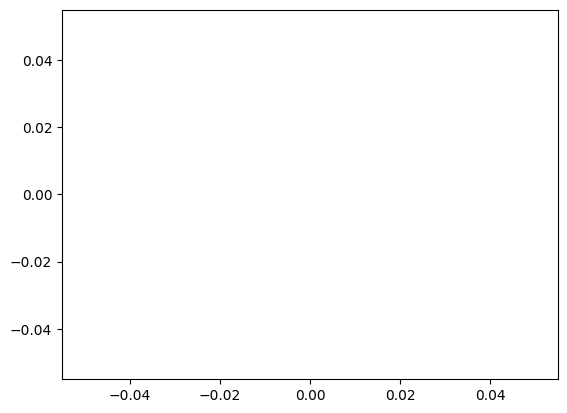

In [11]:
plt.plot(auto_grad_ploss)

In [11]:
policy.detach().numpy()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.94182086,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05817918, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [15]:
torch.tensor(state).float()

tensor([ 0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,  0.9894,  0.4121,
        -0.5440, -1.0000, -0.5366,  0.4202,  0.9906,  0.6503, -0.2879, -0.9614,
        -0.7510,  0.1499,  0.9129,  0.8367, -0.0089, -0.8462, -0.9056, -0.1324,
         0.7626,  0.9564,  0.2709, -0.6636, -0.9880, -0.4040,  0.5514,  0.9999,
         0.5291, -0.4282, -0.9918, -0.6435,  0.2964,  0.9638,  0.7451, -0.1586,
        -0.9165, -0.8318,  0.0177,  0.8509,  0.9018,  0.1236, -0.7683, -0.9538,
        -0.2624,  0.6702,  0.9866,  0.3959, -0.5588, -0.9998, -0.5216,  0.4362,
         0.9929,  0.6367, -0.3048, -0.9661, -0.7392,  0.1674,  0.9200,  0.8268,
        -0.0266, -0.8555, -0.8979, -0.1148,  0.7739,  0.9511,  0.2538, -0.6768,
        -0.9851, -0.3878,  0.5661,  0.9995,  0.5140, -0.4441, -0.9939, -0.6299,
         0.3132,  0.9684,  0.7332, -0.1761, -0.9235, -0.8218,  0.0354,  0.8601,
         0.8940,  0.1060, -0.7795, -0.9483, -0.2453,  0.6833,  0.9836,  0.3796,
        -0.5734, -0.9992, -0.5064,  0.45

# Analytical Results

In [11]:
class AActor():
    def __init__(self, weights, bias):
        self.W = torch.tensor(weights, requires_grad=False)
        self.b = torch.tensor(bias, requires_grad=False)
        
    def forward(self, state):
        return torch.nn.functional.softmax(self.W @ state + self.b, dim=0)

class ACritic():
    def __init__(self, weights, bias):
        self.W = torch.tensor(weights, requires_grad=False)
        self.b = torch.tensor(bias, requires_grad=False)
        
    def forward(self, state):
        return self.W @ state + self.b

In [12]:
n_actions = len(weights['b_actor'])

aactor  = AActor(weights['W_actor'], weights['b_actor'])
acritic = ACritic(weights['W_critic'], weights['b_critic'])

In [13]:
env = test_env(n_actions)

# initialize environment
state = env.reset()

# store p_loss values
anal_grad_ploss = list()

for _ in range(n_iterations):
    # -- Environment step --
    policy = aactor.forward(torch.tensor(state))
    action = torch.argmax(policy.detach(), dim=0)
    
    next_state, reward, _, _ = env.step(action)
    
    # -- Gradient step --
    
    # Critic
    next_qvals  = acritic.forward(torch.tensor(next_state)) 
    next_policy = aactor.forward(torch.tensor(next_state))
    next_action = torch.argmax(next_policy, dim=0)
    
    target = reward + γ * (next_qvals[next_action] - (λ/α) * log_alpha(next_policy[next_action]))
    
    qvals  = acritic.forward(torch.tensor(state))

    # gradient \nabla_{\theta}Q_{\theta}
    # one-hot matrix
    one_hot_matrix = np.zeros((n_actions, n_actions))
    one_hot_matrix[action, :] = np.ones(n_actions)
    
    one_hot_vector = np.zeros(n_actions)
    one_hot_vector[action] = 1
    
    # element-wise multiplication
    delw_C = (one_hot_matrix) * (qvals[action].numpy() - target.numpy()) * np.array([state for i in range(n_actions)])
    delb_C = (one_hot_vector) * (qvals[action].numpy() - target.numpy()) * np.ones(n_actions)
    
    # Actor
    linear_term  = policy * qvals.detach()
    entropy_term = Tsallis_Entropy(policy, α) # Shannon Entropy
    
    p_loss = -torch.sum(linear_term + entropy_term)
    anal_grad_ploss.append(p_loss.item())

    grad_soft = np.diag(policy) - np.outer(policy, policy)
    delw_A = -(qvals.numpy() - np.log(policy).numpy() - 1) * grad_soft @ np.array([state for i in range(n_actions)])
    delb_A = -(qvals.numpy() - np.log(policy).numpy() - 1) * grad_soft @ np.ones(n_actions)

    # Gradient descent
    aactor.W -= torch.tensor(lr * delw_A)
    aactor.b -= torch.tensor(lr * delb_A)

    acritic.W -= torch.tensor(lr * delw_C)
    acritic.b -= torch.tensor(lr * delb_C)

    state = next_state

    if print_grads == True:
        print("-- Actor --\n")
        print("Actor weights' gradient:\n")
        print(delw_A)
        
        print('\n')
        
        print("Actor bias' gradient:\n")
        print(delb_A)

        print("-- Critic --\n")
        print("Critic weights' gradient:\n")
        print(delw_C)
        
        print('\n')
        
        print("Critic bias' gradient:\n")
        print(delb_C)

-- Actor --

Actor weights' gradient:

[[-0.50608809 -1.01217617]
 [ 0.50608809  1.01217617]]


Actor bias' gradient:

[-0.50608809  0.50608809]
-- Critic --

Critic weights' gradient:

[[-0.         -0.        ]
 [-3.47024012 -6.94048025]]


Critic bias' gradient:

[-0.         -3.47024012]
-- Actor --

Actor weights' gradient:

[[-0.15632012 -0.02426037]
 [ 0.15632012  0.02426037]]


Actor bias' gradient:

[-0.17191307  0.17191307]
-- Critic --

Critic weights' gradient:

[[-0.         -0.        ]
 [-0.54137291 -0.08401932]]


Critic bias' gradient:

[-0.         -0.59537495]
-- Actor --

Actor weights' gradient:

[[ 0.04327554 -0.23207933]
 [-0.04327554  0.23207933]]


Actor bias' gradient:

[ 0.30665772 -0.30665772]
-- Critic --

Critic weights' gradient:

[[-0.07087039  0.38006579]
 [-0.          0.        ]]


Critic bias' gradient:

[-0.50219944 -0.        ]
-- Actor --

Actor weights' gradient:

[[-0.40860336 -0.51773043]
 [ 0.40860336  0.51773043]]


Actor bias' gradient:

[ 

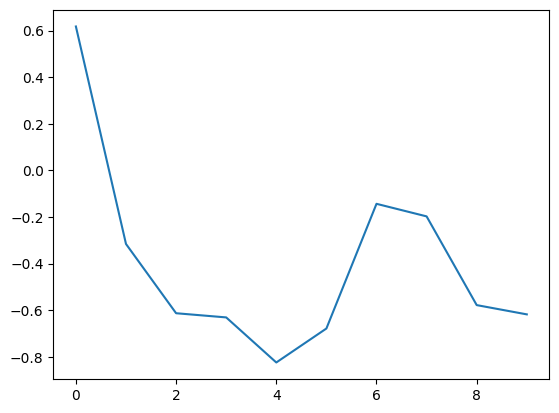

In [14]:
plt.plot(anal_grad_ploss)

# Comparing both methods

In [15]:
dist = np.array(anal_grad_ploss) - np.array(anal_grad_ploss)
print(dist.mean())
print(dist.std())

0.0
0.0
